In [1]:
import csv
import numpy as np
import pandas as pd
# import geopandas as gpd
from IPython.display import Image
# from shapely.geometry import Point, Polygon
from math import factorial
import datetime
import time
import scipy
import scipy.signal
import os, os.path

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression
from patsy import cr

# from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sb


import sys
start_time = time.time()

/Users/hn/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/remote_sensing/python/')

import remote_sensing_core as rc
import remote_sensing_plot_core as rcp

data_dir = "/Users/hn/Documents/01_research_data/remote_sensing/test_Aeolus_data/"
f_name = "01_Regular_filledGap_Grant_SF_2017_EVI.csv"


In [4]:
given_county = "Grant"
SF_year = 2017
indeks = "EVI"
SG_params = 51
delt = 0.4

onset_cut = 0.5
offset_cut = 0.5

regularized = True


In [5]:
SG_win_size = int(SG_params / 10) # grab the first digit as window size
SG_order = SG_params % 10 # grab the second digit as poly. order

print("SG_params is {}.".format(SG_params))
print("SG_win_size is {} and SG_order is {}.".format(SG_win_size, SG_order))


SG_params is 51.
SG_win_size is 5 and SG_order is 1.


In [6]:
a_df = pd.read_csv(data_dir + f_name, low_memory=False)
a_df = a_df[a_df['image_year'] == SF_year] 


In [7]:
a_df['Date'] = pd.to_datetime(a_df.Date.values).values
if "human_system_start_time" in list(a_df.columns):
    a_df['human_system_start_time'] = pd.to_datetime(a_df.human_system_start_time.values).values

In [8]:
a_df = a_df[a_df['county']== given_county.replace("_", " ")] # Filter the given county; given_county
a_df.reset_index(drop=True, inplace=True)

In [9]:
if not('DataSrc' in a_df.columns):
    print ("_________________________________________________________")
    print ("Data source is being set to NA")
    a_df['DataSrc'] = "NA"

a_df = rc.initial_clean(df = a_df, column_to_be_cleaned = indeks)
a_df = a_df.copy()

In [10]:
polygon_list = a_df['ID'].unique()

print ("_________________________________________________________")
print("polygon_list is of length {}.".format(len(polygon_list)))


# 
# 25 columns
#
SEOS_output_columns = ['ID', 'Acres', 'county', 'CropGrp', 'CropTyp', 'DataSrc', 'ExctAcr',
                       'IntlSrD', 'Irrigtn', 'LstSrvD', 'Notes', 'RtCrpTy', 'Shap_Ar',
                       'Shp_Lng', 'TRS', 'image_year', 'SF_year', 'doy', 'EVI',
                       'human_system_start_time', 'Date', 
                       'EVI_ratio', 'SOS', 'EOS', 'season_count']

#
# The reason I am multiplying len(a_df) by 4 is that we can have at least two
# seasons which means 2 SOS and 2 EOS. So, at least 4 rows are needed.
#
all_poly_and_SEOS = pd.DataFrame(data = None, 
                                 index = np.arange(4*len(a_df)), 
                                 columns = SEOS_output_columns)


counter = 0
pointer_SEOS_tab = 0

_________________________________________________________
polygon_list is of length 17705.


In [11]:
###########
###########  Re-order columns of the read data table to be consistent with the output columns
###########
a_df = a_df[SEOS_output_columns[0:21]]

In [12]:
a_poly = polygon_list[1]

curr_field = a_df[a_df['ID']==a_poly].copy()
curr_field.reset_index(drop=True, inplace=True)

if (not("human_system_start_time" in list(curr_field.columns))):
    curr_field = rc.add_human_start_time(curr_field)

curr_field.sort_values(by=['human_system_start_time'], inplace=True)

X = curr_field['doy']
y = curr_field[indeks]


In [13]:
#######################################################################
###
###   Smoothen
###

SG_pred = scipy.signal.savgol_filter(y, window_length= SG_win_size, polyorder=SG_order)
SG_pred[SG_pred > 1 ] = 1
SG_pred[SG_pred < -1 ] = -1

curr_field[indeks] = SG_pred

y_orchard = curr_field[curr_field['doy'] >= 122]
y_orchard = y_orchard[y_orchard['doy'] <= 305]
y_orchard_range = max(y_orchard[indeks]) - min(y_orchard[indeks])

print (y_orchard_range)

0.22275684152121877


In [14]:
curr_field.head(2)

,ID,Acres,county,CropGrp,CropTyp,DataSrc,ExctAcr,IntlSrD,Irrigtn,LstSrvD,...,RtCrpTy,Shap_Ar,Shp_Lng,TRS,image_year,SF_year,doy,EVI,human_system_start_time,Date
0,108538_WSDA_SF_2017,73.0,Grant,Orchard,apple,wsda,72.617809,2006/08/31,micro-sprinkler,2017/04/24,...,NaN,293873.845089,3557.668759,T13R24E4,2017,2017,1,0.351753,2017-01-01,2017-01-01
1,108538_WSDA_SF_2017,73.0,Grant,Orchard,apple,wsda,72.617809,2006/08/31,micro-sprinkler,2017/04/24,...,NaN,293873.845089,3557.668759,T13R24E4,2017,2017,11,0.328086,2017-01-11,2017-01-11


In [27]:
fine_granular_table = rc.create_calendar_table(SF_year = SF_year)
fine_granular_table.head(2)

,Date,SF_year,doy
0,2017-01-01,2017,1
1,2017-01-02,2017,2


In [28]:
curr_field = curr_field[curr_field.image_year == SF_year]
curr_field.head(2)

,ID,Acres,county,CropGrp,CropTyp,DataSrc,ExctAcr,IntlSrD,Irrigtn,LstSrvD,...,RtCrpTy,Shap_Ar,Shp_Lng,TRS,image_year,SF_year,doy,EVI,human_system_start_time,Date
0,108538_WSDA_SF_2017,73.0,Grant,Orchard,apple,wsda,72.617809,2006/08/31,micro-sprinkler,2017/04/24,...,NaN,293873.845089,3557.668759,T13R24E4,2017,2017,1,0.351753,2017-01-01,2017-01-01
1,108538_WSDA_SF_2017,73.0,Grant,Orchard,apple,wsda,72.617809,2006/08/31,micro-sprinkler,2017/04/24,...,NaN,293873.845089,3557.668759,T13R24E4,2017,2017,11,0.328086,2017-01-11,2017-01-11


In [29]:
fine_granular_table = pd.merge(fine_granular_table, curr_field, on=['Date', 'SF_year', 'doy'], how='left')
fine_granular_table.columns

Index(['Date', 'SF_year', 'doy', 'ID', 'Acres', 'county', 'CropGrp', 'CropTyp',
       'DataSrc', 'ExctAcr', 'IntlSrD', 'Irrigtn', 'LstSrvD', 'Notes',
       'RtCrpTy', 'Shap_Ar', 'Shp_Lng', 'TRS', 'image_year', 'EVI',
       'human_system_start_time'],
      dtype='object')

In [30]:
fine_granular_table.head(2)

,Date,SF_year,doy,ID,Acres,county,CropGrp,CropTyp,DataSrc,ExctAcr,...,Irrigtn,LstSrvD,Notes,RtCrpTy,Shap_Ar,Shp_Lng,TRS,image_year,EVI,human_system_start_time
0,2017-01-01,2017,1,108538_WSDA_SF_2017,73.0,Grant,Orchard,apple,wsda,72.617809,...,micro-sprinkler,2017/04/24,NaN,NaN,293873.845089,3557.668759,T13R24E4,2017.0,0.351753,2017-01-01
1,2017-01-02,2017,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [31]:
fine_granular_table["image_year"] = curr_field["image_year"].unique()[0]
fine_granular_table["ID"] = curr_field["ID"].unique()[0]
fine_granular_table["Acres"] = curr_field["Acres"].unique()[0]
fine_granular_table["county"] = curr_field["county"].unique()[0]

fine_granular_table["CropGrp"] = curr_field["CropGrp"].unique()[0]
fine_granular_table["CropTyp"] = curr_field["CropTyp"].unique()[0]
fine_granular_table["DataSrc"] = curr_field["DataSrc"].unique()[0]
fine_granular_table["ExctAcr"] = curr_field["ExctAcr"].unique()[0]

fine_granular_table["IntlSrD"] = curr_field["IntlSrD"].unique()[0]
fine_granular_table["Irrigtn"] = curr_field["Irrigtn"].unique()[0]

fine_granular_table["LstSrvD"] = curr_field["LstSrvD"].unique()[0]
fine_granular_table["Notes"] = curr_field["Notes"].unique()[0]
fine_granular_table["RtCrpTy"] = curr_field["RtCrpTy"].unique()[0]
fine_granular_table["Shap_Ar"] = curr_field["Shap_Ar"].unique()[0]
fine_granular_table["Shp_Lng"] = curr_field["Shp_Lng"].unique()[0]
fine_granular_table["TRS"] = curr_field["TRS"].unique()[0]
fine_granular_table.head(2)

,Date,SF_year,doy,ID,Acres,county,CropGrp,CropTyp,DataSrc,ExctAcr,...,Irrigtn,LstSrvD,Notes,RtCrpTy,Shap_Ar,Shp_Lng,TRS,image_year,EVI,human_system_start_time
0,2017-01-01,2017,1,108538_WSDA_SF_2017,73.0,Grant,Orchard,apple,wsda,72.617809,...,micro-sprinkler,2017/04/24,NaN,NaN,293873.845089,3557.668759,T13R24E4,2017,0.351753,2017-01-01
1,2017-01-02,2017,2,108538_WSDA_SF_2017,73.0,Grant,Orchard,apple,wsda,72.617809,...,micro-sprinkler,2017/04/24,NaN,NaN,293873.845089,3557.668759,T13R24E4,2017,NaN,NaT


In [32]:
fine_granular_table = rc.add_human_start_time_by_YearDoY(fine_granular_table)
fine_granular_table.head(2)

,Date,SF_year,doy,ID,Acres,county,CropGrp,CropTyp,DataSrc,ExctAcr,...,Irrigtn,LstSrvD,Notes,RtCrpTy,Shap_Ar,Shp_Lng,TRS,image_year,EVI,human_system_start_time
0,2017-01-01,2017,1,108538_WSDA_SF_2017,73.0,Grant,Orchard,apple,wsda,72.617809,...,micro-sprinkler,2017/04/24,NaN,NaN,293873.845089,3557.668759,T13R24E4,2017,0.351753,2017-01-01
1,2017-01-02,2017,2,108538_WSDA_SF_2017,73.0,Grant,Orchard,apple,wsda,72.617809,...,micro-sprinkler,2017/04/24,NaN,NaN,293873.845089,3557.668759,T13R24E4,2017,NaN,2017-01-02


In [33]:
# replace NAs with -1.5. Because, that is what the function fill_theGap_linearLine()
# uses as indicator for missing values
fine_granular_table.fillna(value={indeks:-1.5}, inplace=True)


In [34]:
fine_granular_table.head(3)

,Date,SF_year,doy,ID,Acres,county,CropGrp,CropTyp,DataSrc,ExctAcr,...,Irrigtn,LstSrvD,Notes,RtCrpTy,Shap_Ar,Shp_Lng,TRS,image_year,EVI,human_system_start_time
0,2017-01-01,2017,1,108538_WSDA_SF_2017,73.0,Grant,Orchard,apple,wsda,72.617809,...,micro-sprinkler,2017/04/24,NaN,NaN,293873.845089,3557.668759,T13R24E4,2017,0.351753,2017-01-01
1,2017-01-02,2017,2,108538_WSDA_SF_2017,73.0,Grant,Orchard,apple,wsda,72.617809,...,micro-sprinkler,2017/04/24,NaN,NaN,293873.845089,3557.668759,T13R24E4,2017,-1.500000,2017-01-02
2,2017-01-03,2017,3,108538_WSDA_SF_2017,73.0,Grant,Orchard,apple,wsda,72.617809,...,micro-sprinkler,2017/04/24,NaN,NaN,293873.845089,3557.668759,T13R24E4,2017,-1.500000,2017-01-03


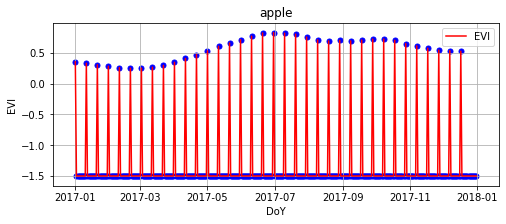

In [35]:
fig, ax = plt.subplots(figsize=(8,3));
plot_title = fine_granular_table.CropTyp.unique()[0]

ax.plot(fine_granular_table['Date'], fine_granular_table['EVI'], c='r', label="EVI")

ax.scatter(fine_granular_table['Date'], fine_granular_table['EVI'], marker='o', s=25, c='b')

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)

In [36]:
fine_granular_table = rc.fill_theGap_linearLine(regular_TS = fine_granular_table, V_idx=indeks, SF_year=SF_year)

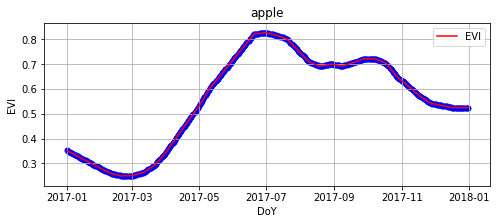

In [37]:
fig, ax = plt.subplots(figsize=(8,3));
plot_title = fine_granular_table.CropTyp.unique()[0]

ax.plot(fine_granular_table['Date'], fine_granular_table['EVI'], c='r', label="EVI")

ax.scatter(fine_granular_table['Date'], fine_granular_table['EVI'], marker='o', s=25, c='b')

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)

In [54]:
fine_granular_table = rc.addToDF_SOS_EOS_White(pd_TS = fine_granular_table, 
                                               VegIdx = indeks, 
                                               onset_thresh = onset_cut, 
                                               offset_thresh = offset_cut)

##
##  Kill false detected seasons 
##
fine_granular_table = rc.Null_SOS_EOS_by_DoYDiff(pd_TS = fine_granular_table, min_season_length=40)

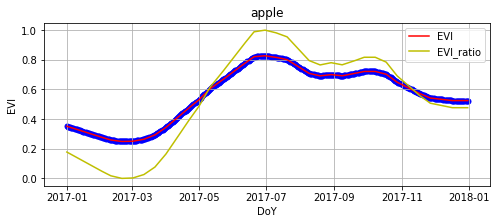

In [55]:
fig, ax = plt.subplots(figsize=(8,3));
plot_title = fine_granular_table.CropTyp.unique()[0]

ax.plot(fine_granular_table['Date'], fine_granular_table['EVI'], c='r', label="EVI")
ax.plot(fine_granular_table['Date'], fine_granular_table['EVI_ratio'], c='y', label="EVI_ratio")


ax.scatter(fine_granular_table['Date'], fine_granular_table['EVI'], marker='o', s=25, c='b')

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)

In [61]:
SEOS = fine_granular_table[(fine_granular_table['SOS'] != 0) | fine_granular_table['EOS'] != 0]
SEOS = SEOS.copy()
# SEOS = SEOS.reset_index() # not needed really
SOS_tb = fine_granular_table[fine_granular_table['SOS'] != 0]
EOS_tb = fine_granular_table[fine_granular_table['EOS'] != 0]

In [57]:
SEOS

,Date,SF_year,doy,ID,Acres,county,CropGrp,CropTyp,DataSrc,ExctAcr,...,RtCrpTy,Shap_Ar,Shp_Lng,TRS,image_year,EVI,human_system_start_time,EVI_ratio,SOS,EOS
122,2017-05-03,2017,123,108538_WSDA_SF_2017,73.0,Grant,Orchard,apple,wsda,72.617809,...,NaN,293873.845089,3557.668759,T13R24E4,2017,0.545033,2017-05-03,0.512089,0.545033,0.000000
335,2017-12-02,2017,336,108538_WSDA_SF_2017,73.0,Grant,Orchard,apple,wsda,72.617809,...,NaN,293873.845089,3557.668759,T13R24E4,2017,0.537844,2017-12-02,0.499653,0.000000,0.537844


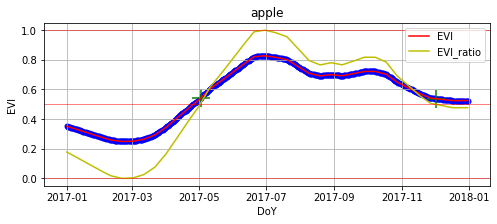

In [62]:
fig, ax = plt.subplots(figsize=(8,3));
plot_title = fine_granular_table.CropTyp.unique()[0]

ax.plot(fine_granular_table['Date'], fine_granular_table['EVI'], c='r', label="EVI")
ax.plot(fine_granular_table['Date'], fine_granular_table['EVI_ratio'], c='y', label="EVI_ratio")

ax.scatter(fine_granular_table['Date'], fine_granular_table['EVI'], marker='o', s=25, c='b')

ax.axhline(0 , color = 'r', linewidth=.5)
ax.axhline(0.5 , color = 'r', linewidth=.5)
ax.axhline(1 , color = 'r', linewidth=.5)

ax.scatter(SOS_tb['Date'], SOS_tb['SOS'], marker='+', s=300, c='g')
ax.scatter(EOS_tb['Date'], EOS_tb['EOS'], marker='+', s=300, c='g')
# ax.axhline(-1, color = 'r', linewidth=.5)

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)

In [52]:
fine_granular_table.head(2)

,Date,SF_year,doy,ID,Acres,county,CropGrp,CropTyp,DataSrc,ExctAcr,...,RtCrpTy,Shap_Ar,Shp_Lng,TRS,image_year,EVI,human_system_start_time,EVI_ratio,SOS,EOS
0,2017-01-01,2017,1,108538_WSDA_SF_2017,73.0,Grant,Orchard,apple,wsda,72.617809,...,NaN,293873.845089,3557.668759,T13R24E4,2017,0.351753,2017-01-01,0.177778,0.0,0.0
1,2017-01-02,2017,2,108538_WSDA_SF_2017,73.0,Grant,Orchard,apple,wsda,72.617809,...,NaN,293873.845089,3557.668759,T13R24E4,2017,0.349387,2017-01-02,0.173685,0.0,0.0


In [ ]:
regular_TS = fine_granular_table
V_idx = indeks
a_regularized_TS = regular_TS.copy()

if (len(a_regularized_TS.image_year.unique()) == 2):
    x_axis = extract_XValues_of_2Yrs_TS(regularized_TS = a_regularized_TS, SF_yr = SF_year)
elif (len(a_regularized_TS.image_year.unique()) == 3):
    x_axis = extract_XValues_of_3Yrs_TS(regularized_TS = a_regularized_TS, SF_yr = SF_year)
elif (len(a_regularized_TS.image_year.unique()) == 1):
    x_axis = a_regularized_TS["doy"].copy()

TS_array = a_regularized_TS[V_idx].copy().values

"""
TS_array[0] = -1.5
TS_array[51] = -1.5
TS_array[52] = -1.5
TS_array[53] = -1.5
TS_array.shape
"""

"""
-1.5 is an indicator of missing values by Sentinel, i.e. a gap.
The -1.5 was used as indicator in the function regularize_movingWindow_windowSteps_2Yrs()
"""
missing_indicies = np.where(TS_array == -1.5)[0]
Notmissing_indicies = np.where(TS_array != -1.5)[0]

In [ ]:
#
#    Check if the first or last k values are missing
#    if so, replace them with proper number and shorten the task
#
left_pointer = Notmissing_indicies[0]
right_pointer = Notmissing_indicies[-1]


In [ ]:
TS_array[0:5]

In [ ]:
TS_array[360:]

In [ ]:
if left_pointer > 0:
    TS_array[:left_pointer] = TS_array[left_pointer]

if right_pointer < (len(TS_array) - 1):
    TS_array[right_pointer:] = TS_array[right_pointer]

In [ ]:

#    
# update indexes.
#
missing_indicies = np.where(TS_array == -1.5)[0]
Notmissing_indicies = np.where(TS_array != -1.5)[0]

In [ ]:
# left_pointer = Notmissing_indicies[0]
stop = right_pointer
right_pointer = left_pointer + 1

In [ ]:
print (stop)
print (right_pointer)

In [ ]:
TS_array[0:4]

In [ ]:
missing_indicies = np.where(TS_array == -1.5)[0]

In [ ]:
left_pointer = missing_indicies[0] - 1
left_value = TS_array[left_pointer]
right_pointer = missing_indicies[0]

In [ ]:
print(left_pointer)
print(right_pointer)

In [ ]:
while TS_array[right_pointer] == -1.5:
        right_pointer += 1

In [ ]:
print(right_pointer)

In [ ]:
TS_array[0:12]

In [ ]:
right_value = TS_array[right_pointer]
right_value

In [ ]:
right_pointer - left_pointer

In [ ]:
slope = (right_value - left_value) / (x_axis[right_pointer] - x_axis[left_pointer]) # a
b = right_value - (slope * x_axis[right_pointer])
TS_array[left_pointer+1 : right_pointer]

In [ ]:
TS_array[left_pointer+1 : right_pointer] = slope * x_axis[left_pointer+1 : right_pointer] + b
TS_array[0:12]

In [ ]:
left_pointer = missing_indicies[0] - 1
left_value = TS_array[left_pointer]
right_pointer = missing_indicies[0]

In [ ]:
print (left_pointer)
print (right_pointer)

In [ ]:
while TS_array[right_pointer] == -1.5:
    right_pointer += 1
right_value = TS_array[right_pointer]

In [ ]:
print (left_pointer)
print (right_pointer)

In [ ]:
slope = (right_value - left_value) / (x_axis[right_pointer] - x_axis[left_pointer]) # a
b = right_value - (slope * x_axis[right_pointer])

In [ ]:
print (TS_array[left_pointer+1 : right_pointer])
TS_array[left_pointer+1 : right_pointer] = slope * x_axis[left_pointer+1 : right_pointer] + b
missing_indicies = np.where(TS_array == -1.5)[0]
TS_array[left_pointer+1 : right_pointer]

In [ ]:
TS_array[8 : 22]

In [ ]:
right_pointer

In [ ]:
while len(missing_indicies) > 0:
    left_pointer = missing_indicies[0] - 1
    left_value = TS_array[left_pointer]
    right_pointer = missing_indicies[0]

    while TS_array[right_pointer] == -1.5:
        right_pointer += 1
    right_value = TS_array[right_pointer]

    if (right_pointer - left_pointer) == 2:
        # if there is a single gap, then we have just average of the
        # values
        # Avoid extra computation!
        #
        TS_array[left_pointer + 1] = 0.5 * (TS_array[left_pointer] + TS_array[right_pointer])
    else:
        # form y= ax + b
        slope = (right_value - left_value) / (x_axis[right_pointer] - x_axis[left_pointer]) # a
        b = right_value - (slope * x_axis[right_pointer])
        TS_array[left_pointer+1 : right_pointer] = slope * x_axis[left_pointer+1 : right_pointer] + b
        missing_indicies = np.where(TS_array == -1.5)[0]


a_regularized_TS[V_idx] = TS_array

In [ ]:
fine_granular_table = rc.fill_theGap_linearLine(regular_TS = fine_granular_table, V_idx=indeks, SF_year=SF_year)

In [ ]:
fig, ax = plt.subplots(figsize=(8,3));
plot_title = fine_granular_table.CropTyp.unique()[0]

ax.plot(fine_granular_table['Date'], fine_granular_table['EVI'], c='r', label="EVI")

ax.scatter(fine_granular_table['Date'], fine_granular_table['EVI'], marker='o', s=25, c='b')

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)

In [ ]:
fine_granular_table = rc.addToDF_SOS_EOS_White(pd_TS = fine_granular_table, 
                                               VegIdx = indeks, 
                                               onset_thresh = onset_cut, 
                                               offset_thresh = offset_cut)

In [ ]:
print(np.array(fine_granular_table.SOS))

In [ ]:
fine_granular_table = rc.addToDF_SOS_EOS_White(pd_TS = fine_granular_table, 
                                               VegIdx = indeks, 
                                               onset_thresh = onset_cut, 
                                               offset_thresh = offset_cut)

##
##  Kill false detected seasons 
##
fine_granular_table = rc.Null_SOS_EOS_by_DoYDiff(pd_TS = fine_granular_table, min_season_length=40)

In [ ]:
SEOS = fine_granular_table[(fine_granular_table['SOS'] != 0) | fine_granular_table['EOS'] != 0]
SEOS = SEOS.copy()
# SEOS = SEOS.reset_index() # not needed really
SOS_tb = fine_granular_table[fine_granular_table['SOS'] != 0]

In [ ]:
fine_granular_table

In [ ]:
def fill_theGap_linearLine(regular_TS, V_idx, SF_year):

    a_regularized_TS = regular_TS.copy()

    if (len(a_regularized_TS.image_year.unique()) == 2):
        x_axis = extract_XValues_of_2Yrs_TS(regularized_TS = a_regularized_TS, SF_yr = SF_year)
    elif (len(a_regularized_TS.image_year.unique()) == 3):
        x_axis = extract_XValues_of_3Yrs_TS(regularized_TS = a_regularized_TS, SF_yr = SF_year)
    elif (len(a_regularized_TS.image_year.unique()) == 1):
        x_axis = a_regularized_TS["doy"].copy()

    TS_array = a_regularized_TS[V_idx].copy().values

    """
    TS_array[0] = -1.5
    TS_array[51] = -1.5
    TS_array[52] = -1.5
    TS_array[53] = -1.5
    TS_array.shape
    """

    """
    -1.5 is an indicator of missing values by Sentinel, i.e. a gap.
    The -1.5 was used as indicator in the function regularize_movingWindow_windowSteps_2Yrs()
    """
    missing_indicies = np.where(TS_array == -1.5)[0]
    Notmissing_indicies = np.where(TS_array != -1.5)[0]

    #
    #    Check if the first or last k values are missing
    #    if so, replace them with proper number and shorten the task
    #
    left_pointer = Notmissing_indicies[0]
    right_pointer = Notmissing_indicies[-1]

    if left_pointer > 0:
        TS_array[:left_pointer] = TS_array[left_pointer]

    if right_pointer < (len(TS_array) - 1):
        TS_array[right_pointer:] = TS_array[right_pointer]
    #    
    # update indexes.
    #
    missing_indicies = np.where(TS_array == -1.5)[0]
    Notmissing_indicies = np.where(TS_array != -1.5)[0]

    # left_pointer = Notmissing_indicies[0]
    stop = right_pointer
    right_pointer = left_pointer + 1

    missing_indicies = np.where(TS_array == -1.5)[0]

    while len(missing_indicies) > 0:
        left_pointer = missing_indicies[0] - 1
        left_value = TS_array[left_pointer]
        
        right_pointer = missing_indicies[0]
        
        while TS_array[right_pointer] == -1.5:
            right_pointer += 1
        
        right_value = TS_array[right_pointer]
        
        if (right_pointer - left_pointer) == 2:
            # if there is a single gap, then we have just average of the
            # values
            # Avoid extra computation!
            #
            TS_array[left_pointer + 1] = 0.5 * (TS_array[left_pointer] + TS_array[right_pointer])
        else:
            # form y= ax + b
            slope = (right_value - left_value) / (x_axis[right_pointer] - x_axis[left_pointer]) # a
            b = right_value - (slope * x_axis[right_pointer])
            TS_array[left_pointer+1 : right_pointer] = slope * x_axis[left_pointer+1 : right_pointer] + b
            missing_indicies = np.where(TS_array == -1.5)[0]
            
        
    a_regularized_TS[V_idx] = TS_array
    return (a_regularized_TS)


In [ ]:
import numpy as np

array = [1, 2, 1, 3, 4, 5, 1]
item = 1
np_array = np.array(array)
item_index = np.where(np_array==item)
print (item_index)

In [ ]:
TS_array = np.array(TS_array)
item_index = np.where(TS_array == -1.5)
print (item_index)

In [ ]:
TS_array[2]

In [ ]:
TS_array[0:10]